In [14]:
import wandb
wandb.login()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: olgatrofimova96 (use `wandb login --relogin` to force relogin)


True

In [1]:
import numpy as np
import os
import shutil
import random
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torchvision
from torchvision import transforms

from sklearn.metrics import roc_auc_score, roc_curve

from PIL import Image

In [2]:
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

set_seed(24)

Create folders for train, validation and test.

In [3]:
data_root = '/home/olga/Desktop/Eyes/'
train_dir = 'train'
val_dir = 'val'
test_dir = 'test'

class_names = ['close', 'open']

for dir_name in [train_dir, val_dir, test_dir]:
    for class_name in class_names:
        os.makedirs(os.path.join(dir_name, class_name), exist_ok=True)

Originally files have no any order and structure, so there is no need to suffle them.
Every third image goes into the training folder, every fourth goes into the validation folder, and the rest go into the test folder.

In [5]:
for class_name in class_names:
    source_dir = os.path.join(data_root, class_name)
    for i, file_name in enumerate(os.listdir(source_dir)):
        if i % 3 != 0:
            dest_dir = os.path.join(train_dir, class_name)
        elif i % 4 != 0:
            dest_dir = os.path.join(val_dir, class_name)
        else:
            dest_dir = os.path.join(test_dir, class_name)
        shutil.copy(os.path.join(source_dir, file_name), os.path.join(dest_dir, file_name))

In [4]:
train_transforms = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomAdjustSharpness(sharpness_factor=2),
    transforms.RandomAutocontrast(),
    transforms.ToTensor()
])

val_transforms = transforms.Compose([
    transforms.ToTensor()
])

train_dataset = torchvision.datasets.ImageFolder(train_dir, train_transforms)
val_dataset = torchvision.datasets.ImageFolder(val_dir, val_transforms)

batch_size = 16
train_dataloader = torch.utils.data.DataLoader(train_dataset, 
                                               batch_size=batch_size, 
                                               shuffle=True, 
                                               num_workers=2)

val_dataloader = torch.utils.data.DataLoader(val_dataset, 
                                             batch_size=batch_size, 
                                             shuffle=True, 
                                             num_workers=2)

In [5]:
images, labels = next(iter(train_dataloader))

In [6]:
def show_imgs(imgs, labels):
    f, axes= plt.subplots(1, len(imgs), figsize=(15,1))
    for i, axis in enumerate(axes):
      axes[i].imshow(np.squeeze(np.transpose(imgs[i].numpy(), (1, 2, 0))), cmap='gray')
      axes[i].set_title(labels[i].numpy())
    return f

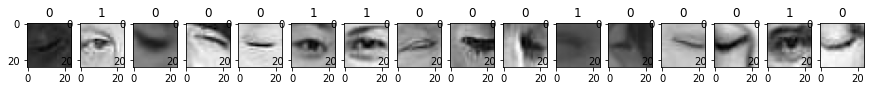

In [7]:
show_imgs(images, labels);

In [39]:
def eer(label, pred, positive_label=1):
    # all fpr, tpr, fnr, fnr, threshold are lists (in the format of np.array)
    fpr, tpr, threshold = roc_curve(label, pred, pos_label=positive_label)
    fnr = 1 - tpr

    # the threshold of fnr == fpr
    eer_threshold = threshold[np.nanargmin(np.absolute((fnr - fpr)))]

    # theoretically eer from fpr and eer from fnr should be identical but they can be slightly differ in reality
    eer_1 = fpr[np.nanargmin(np.absolute((fnr - fpr)))]
    eer_2 = fnr[np.nanargmin(np.absolute((fnr - fpr)))]

    # return the mean of eer from fpr and from fnr
    eer = (eer_1 + eer_2) / 2
    return eer, eer_threshold

In [9]:
class ConvNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.enc_conv = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=5),            
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(16, 32, kernel_size=3),            
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(2, 2),
            
            nn.Conv2d(32, 64, kernel_size=3),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(2, 2)
            )

        self.flatten = nn.Flatten()
        self.enc_lin = nn.Sequential(
            nn.Linear(64, 32),
            nn.ReLU(),            
            nn.Linear(32, 1)
            )
        self.act = nn.Sigmoid()
    
        
    def forward(self, x):
        x = self.enc_conv(x)
        x = self.flatten(x)
        x = self.enc_lin(x)
        x = self.act(x)
        
        return x

In [10]:
model = ConvNet()

In [11]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

loss = torch.nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=3.0e-3)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

In [63]:
def train_model(model, loss, optimizer, scheduler, num_epochs):
    run = wandb.init(project='eyes')
    for epoch in range(num_epochs):
        print('Epoch {}/{}:'.format(epoch, num_epochs - 1), flush=True)

        for phase in ['train', 'val']:
            if phase == 'train':
                dataloader = train_dataloader
                model.train()
                scheduler.step()                
            else:
                dataloader = val_dataloader
                model.eval()

            running_loss, running_acc = 0.0, 0.0
            y_pred, y_true = [], []

            for inputs, labels in dataloader:
                inputs = inputs.to(device)
                labels = labels.to(device).to(torch.float32).unsqueeze(-1)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    preds = model(inputs)
                    loss_value = loss(preds, labels)

                    if phase == 'train':
                        loss_value.backward()
                        optimizer.step()

                running_loss += loss_value.item()
                
                threshold = 0.5
                round_preds = preds.cpu().detach() > threshold
                running_acc += (round_preds ==  labels.cpu()).float().mean()

                
                y_true.extend(labels.cpu().view(-1).numpy())
                y_pred.extend(preds.cpu().detach().numpy())
                epoch_eer = eer(y_true, y_pred)[0]
                                
            epoch_loss = running_loss / len(dataloader)
            epoch_acc = running_acc / len(dataloader)
            
            wandb.log({f"{phase}_loss": epoch_loss})
            wandb.log({f"{phase}_acc": epoch_acc})
            wandb.log({f"{phase}_EER": epoch_eer})

            print('{} Loss: {:.4f} Acc: {:.4f} EER: {:.4f}'.format(phase, epoch_loss, epoch_acc, epoch_eer), flush=True)
    return model

In [64]:
train_model(model, loss, optimizer, scheduler, num_epochs=20);

Epoch 0/19:


/home/olga/anaconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:129: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


train Loss: 0.3137 Acc: 0.8557 EER: 0.1421
val Loss: 0.2891 Acc: 0.8720 EER: 0.0770
Epoch 1/19:
train Loss: 0.2164 Acc: 0.9116 EER: 0.0851
val Loss: 0.2035 Acc: 0.9097 EER: 0.0640
Epoch 2/19:
train Loss: 0.1632 Acc: 0.9376 EER: 0.0626
val Loss: 0.1956 Acc: 0.9157 EER: 0.0620
Epoch 3/19:
train Loss: 0.1617 Acc: 0.9360 EER: 0.0630
val Loss: 0.2223 Acc: 0.8988 EER: 0.1021
Epoch 4/19:
train Loss: 0.1521 Acc: 0.9465 EER: 0.0574
val Loss: 0.1280 Acc: 0.9514 EER: 0.0440
Epoch 5/19:
train Loss: 0.1148 Acc: 0.9585 EER: 0.0428
val Loss: 0.1246 Acc: 0.9573 EER: 0.0420
Epoch 6/19:
train Loss: 0.1107 Acc: 0.9592 EER: 0.0409
val Loss: 0.1201 Acc: 0.9593 EER: 0.0430
Epoch 7/19:
train Loss: 0.1129 Acc: 0.9532 EER: 0.0465
val Loss: 0.1311 Acc: 0.9474 EER: 0.0420
Epoch 8/19:
train Loss: 0.1127 Acc: 0.9590 EER: 0.0428
val Loss: 0.1206 Acc: 0.9544 EER: 0.0480
Epoch 9/19:
train Loss: 0.0965 Acc: 0.9671 EER: 0.0338
val Loss: 0.1210 Acc: 0.9573 EER: 0.0460
Epoch 10/19:
train Loss: 0.1017 Acc: 0.9588 EER: 0.0

In [12]:
test_dataset = torchvision.datasets.ImageFolder(test_dir, val_transforms)
test_dataloader = torch.utils.data.DataLoader(test_dataset, 
                                             batch_size=batch_size, 
                                             shuffle=False, 
                                             num_workers=2)

In [13]:
# model.load_state_dict(torch.load('best_model.pt'))

<All keys matched successfully>

In [14]:
def test_model(model, test_dataloader):
    test_predictions, test_labels = [], []
    model.eval()
    model = model.to(device)

    for inputs, labels in test_dataloader:
        inputs = inputs.to(device)
        with torch.set_grad_enabled(False):
            preds = model(inputs)
        test_predictions.append(preds.data.cpu().numpy())
        test_labels.append(labels)

    test_predictions = np.concatenate(test_predictions)
    test_labels = np.concatenate(test_labels)
    return test_predictions, test_labels

In [15]:
test_predictions, test_labels = test_model(model, test_dataloader)

/home/olga/anaconda3/lib/python3.8/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


In [30]:
file_names = []
for (dirpath, dirnames, filenames) in os.walk(test_dir):
    file_names.extend(filenames)

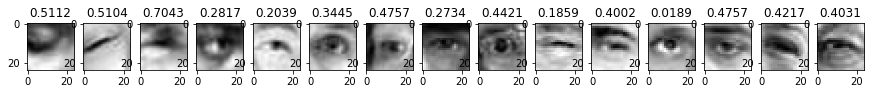

In [42]:
imgs, lbls = [], []
for i in range(len(test_predictions)):
    if np.round(test_predictions[i][0]) != test_labels[i]:
        if test_labels[i] > 0.5:
            dir = 'open/'
        else:
            dir = 'close/'
        source_dir = os.path.join(test_dir, dir)
        image = Image.open('{}/{}'.format(source_dir, file_names[i]))
        imgs.append(val_transforms(image))
        lbls.append(torch.tensor(np.round(test_predictions[i][0], 4)))

show_imgs(imgs, lbls);

In [27]:
def show_roc_curve(test_labels, test_predictions):
    res = eer(test_labels, test_predictions)
    print(f'EER: {res}')
    score = roc_auc_score(test_labels, test_predictions)
    print(f'roc-auc: {score}')

    f, ax = plt.subplots(1, 1, figsize=(12, 8))
    plt.plot(*roc_curve(test_labels, test_predictions)[:2], label='ROC (area = {:.4})'.format(score))
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
    plt.plot([1, 0], [0, 1], linestyle='--', color='gray')
    plt.plot([0.05, 0.05], [0, 1], linestyle='-', color='red')
    plt.plot([res[0], res[0]], [0, 1], linestyle='-', color='green')
    plt.legend()
    plt.grid(True)
    return f

EER: (0.03287395923054835, 0.4002069)
roc-auc: 0.9939707149009475


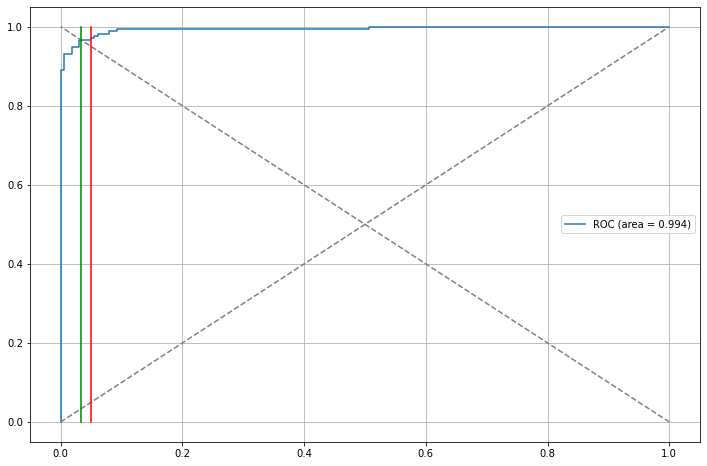

In [44]:
res = show_roc_curve(test_labels, test_predictions);

In [ ]:
wandb.log({"ROC-AUC": wandb.Image(res)})
wandb.finish()

In [202]:
torch.save(model.state_dict(), '/home/olga/Desktop/Eyes/best_model.pt')
torch.save(model, '/home/olga/Desktop/Eyes/best_entire_model.pt')